In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

In [23]:
load_dotenv()
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "healthstock_dwh")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASS = os.getenv("DB_PASSWORD")

PROCESSED = "../data/processed/"
DWH_DIR   = "../data/processed/dwh/"
os.makedirs(DWH_DIR, exist_ok=True)

In [24]:
master = pd.read_csv(f"{PROCESSED}master_integrated.csv")
bps    = pd.read_csv(f"{PROCESSED}bps_health_clean.csv")
fmcg   = pd.read_csv("../data/raw/FMCG_2022_2024.csv")
fmcg["date"] = pd.to_datetime(fmcg["date"])

print(f"master_integrated : {master.shape}")
print(f"bps_health_clean  : {bps.shape}")
print(f"fmcg raw          : {fmcg.shape}")

master_integrated : (108, 24)
bps_health_clean  : (190, 4)
fmcg raw          : (190757, 14)


In [25]:
# Dim_Island_Group
dim_island_group = pd.DataFrame({
    "island_group_id"  : [1, 2, 3, 4],
    "island_group_name": [
        "Sumatera & Kalimantan Barat",
        "Jawa, Bali & Nusa Tenggara",
        "Kalimantan & Sulawesi",
        "Maluku & Papua"
    ],
    "description": [
        "Western Indonesia: Sumatera island group and West Kalimantan",
        "Central Indonesia: Java, Bali and Lesser Sunda Islands",
        "Northern Indonesia: Borneo (excl. West) and Sulawesi",
        "Eastern Indonesia: Maluku archipelago and Papua"
    ]
})
print(f"Dim_Island_Group  : {dim_island_group.shape}")
print(dim_island_group[["island_group_id", "island_group_name"]].to_string(index=False))

# Dim_Category
categories = fmcg["category"].unique()
dim_category = pd.DataFrame({
    "category_id"      : range(1, len(categories) + 1),
    "category_name"    : sorted(categories),
    "is_health_related": [c in ["Milk", "Juice"] for c in sorted(categories)],
    "description"      : [
        "Dairy products",
        "Fruit-based beverages",
        "Ready-to-eat meal products",
        "Confectionery and cereal bars",
        "Cultured dairy products"
    ]
})
print(f"\nDim_Category      : {dim_category.shape}")
print(dim_category[["category_id", "category_name", "is_health_related"]].to_string(index=False))

Dim_Island_Group  : (4, 3)
 island_group_id           island_group_name
               1 Sumatera & Kalimantan Barat
               2  Jawa, Bali & Nusa Tenggara
               3       Kalimantan & Sulawesi
               4              Maluku & Papua

Dim_Category      : (5, 4)
 category_id category_name  is_health_related
           1         Juice               True
           2          Milk               True
           3     ReadyMeal              False
           4      SnackBar              False
           5        Yogurt              False


In [26]:
# Dim_Region
# PL-region → island_group_id mapping
region_data = [
    ("PL-West",    1, "Sumatera & West Kalimantan distribution zone"),
    ("PL-Central", 2, "Java, Bali & Nusa Tenggara distribution zone"),
    ("PL-North",   3, "Kalimantan & Sulawesi distribution zone"),
    ("PL-South",   4, "Maluku & Papua distribution zone"),
]
dim_region = pd.DataFrame(region_data,
    columns=["pl_region", "island_group_id", "region_description"])
dim_region.insert(0, "region_id", range(1, len(dim_region) + 1))

print(f"Dim_Region        : {dim_region.shape}")
print(dim_region[["region_id", "pl_region", "island_group_id"]].to_string(index=False))

# Dim_Product 
# References Dim_Category via category_id
cat_lookup   = dim_category[["category_id", "category_name"]].rename(
    columns={"category_name": "category"})
product_keys = fmcg[["sku", "brand", "segment", "category", "pack_type"]] \
    .drop_duplicates().sort_values(["category", "sku"]).reset_index(drop=True)
product_keys = product_keys.merge(cat_lookup, on="category", how="left")
product_keys.insert(0, "product_id", range(1, len(product_keys) + 1))

dim_product = product_keys[["product_id", "sku", "brand", "segment", "pack_type", "category_id"]] \
    .rename(columns={
        "sku"    : "sku_code",
        "brand"  : "brand_name",
        "segment": "market_segment",
    })

print(f"\nDim_Product       : {dim_product.shape}")

Dim_Region        : (4, 4)
 region_id  pl_region  island_group_id
         1    PL-West                1
         2 PL-Central                2
         3   PL-North                3
         4   PL-South                4

Dim_Product       : (90, 6)


In [ ]:
# Dim_time
dates    = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")
dim_time = pd.DataFrame({"full_date": dates})
dim_time["time_id"]          = range(1, len(dim_time) + 1)
dim_time["year"]             = dim_time["full_date"].dt.year
dim_time["quarter"]          = dim_time["full_date"].dt.quarter
dim_time["month"]            = dim_time["full_date"].dt.month
dim_time["month_name"]       = dim_time["full_date"].dt.strftime("%B")
dim_time["week_of_year"]     = dim_time["full_date"].dt.isocalendar().week.astype(int)
dim_time["day_of_week"]      = dim_time["full_date"].dt.dayofweek
dim_time["day_name"]         = dim_time["full_date"].dt.strftime("%A")
dim_time["is_weekend"]       = (dim_time["day_of_week"] >= 5)
dim_time["year_month"]       = dim_time["full_date"].dt.strftime("%Y-%m")
dim_time["full_date"]        = dim_time["full_date"].dt.strftime("%Y-%m-%d")

rainy_months = [10,11,12,1,2,3]; dengue_months = [1,2,3]; school_months = [6,7,12,1]
ramadan = {2022:[4], 2023:[3,4], 2024:[3]}; lebaran = {2022:[5], 2023:[4,5], 2024:[4]}

dim_time["is_rainy_season"]   = dim_time["month"].isin(rainy_months)
dim_time["is_dengue_peak"]    = dim_time["month"].isin(dengue_months)
dim_time["is_school_holiday"] = dim_time["month"].isin(school_months)
dim_time["is_ramadan"]        = dim_time.apply(lambda r: r["month"] in ramadan.get(r["year"],[]), axis=1)
dim_time["is_lebaran"]        = dim_time.apply(lambda r: r["month"] in lebaran.get(r["year"],[]), axis=1)
dim_time = dim_time[[
    "time_id","full_date","year","quarter","month","month_name",
    "week_of_year","day_of_week","day_name","is_weekend","year_month",
    "is_rainy_season","is_dengue_peak","is_school_holiday","is_ramadan","is_lebaran"
]]
print(f"Dim_Time    : {dim_time.shape}")

Dim_Time    : (1096, 16)


In [28]:
# Dim_Location
# References Dim_Region (which references Dim_Island_Group)
province_to_region = {
    "ACEH":"PL-West","SUMATERA UTARA":"PL-West","SUMATERA BARAT":"PL-West",
    "RIAU":"PL-West","JAMBI":"PL-West","SUMATERA SELATAN":"PL-West",
    "BENGKULU":"PL-West","LAMPUNG":"PL-West","KEP. BANGKA BELITUNG":"PL-West",
    "KEP. RIAU":"PL-West","KALIMANTAN BARAT":"PL-West",
    "DKI JAKARTA":"PL-Central","JAWA BARAT":"PL-Central","JAWA TENGAH":"PL-Central",
    "DI YOGYAKARTA":"PL-Central","JAWA TIMUR":"PL-Central","BANTEN":"PL-Central",
    "BALI":"PL-Central","NUSA TENGGARA BARAT":"PL-Central","NUSA TENGGARA TIMUR":"PL-Central",
    "KALIMANTAN TENGAH":"PL-North","KALIMANTAN SELATAN":"PL-North",
    "KALIMANTAN TIMUR":"PL-North","KALIMANTAN UTARA":"PL-North",
    "SULAWESI UTARA":"PL-North","SULAWESI TENGAH":"PL-North",
    "SULAWESI SELATAN":"PL-North","SULAWESI TENGGARA":"PL-North",
    "GORONTALO":"PL-North","SULAWESI BARAT":"PL-North",
    "MALUKU":"PL-South","MALUKU UTARA":"PL-South","PAPUA BARAT":"PL-South",
    "PAPUA BARAT DAYA":"PL-South","PAPUA":"PL-South","PAPUA SELATAN":"PL-South",
    "PAPUA TENGAH":"PL-South","PAPUA PEGUNUNGAN":"PL-South",
}

region_id_lookup = dim_region.set_index("pl_region")["region_id"].to_dict()
provinces        = sorted(province_to_region.keys())

dim_location = pd.DataFrame({
    "location_id"  : range(1, len(provinces) + 1),
    "province_name": provinces,
    "region_id"    : [region_id_lookup[province_to_region[p]] for p in provinces],
})
print(f"Dim_Location    : {dim_location.shape}")

Dim_Location    : (38, 3)


In [29]:
# Dim_Health_Context
# References Dim_Region via region_id
health_ctx = master[[
    "year","region","avg_health_complaint_pct",
    "health_risk_score","risk_category","stock_category","strategic_quadrant"
]].drop_duplicates().reset_index(drop=True)
health_ctx.insert(0, "context_id", range(1, len(health_ctx) + 1))
health_ctx["priority_rank"] = health_ctx["strategic_quadrant"].map({
    "🔴 Critical Gap":1, "🟠 Underserved":2, "🟡 Well-Served":3, "🟢 Surplus":4
})
health_ctx["region_id"] = health_ctx["region"].map(region_id_lookup)

dim_health_context = health_ctx[[
    "context_id","year","region_id","avg_health_complaint_pct",
    "health_risk_score","risk_category","stock_category","strategic_quadrant","priority_rank"
]].rename(columns={"avg_health_complaint_pct":"health_complaint_pct"})

print(f"Dim_Health_Context: {dim_health_context.shape}")

Dim_Health_Context: (26, 9)


In [30]:
# Fact_Sales
fmcg_keyed             = fmcg.copy()
fmcg_keyed["date_str"] = fmcg_keyed["date"].dt.strftime("%Y-%m-%d")

time_lkp = dim_time[["time_id","full_date"]].rename(columns={"full_date":"date_str"})
fmcg_keyed = fmcg_keyed.merge(time_lkp, on="date_str", how="left")

prod_lkp = dim_product[["product_id","sku_code","pack_type"]].rename(columns={"sku_code":"sku"})
fmcg_keyed = fmcg_keyed.merge(prod_lkp, on=["sku","pack_type"], how="left")

# Location: map via region_id first, use first province per region as representative
region_loc_id         = dim_location.groupby("region_id")["location_id"].first().reset_index()
pl_to_region_id       = {v:k for k,v in {v:k for k,v in region_id_lookup.items()}.items()}
fmcg_keyed["region_id"] = fmcg_keyed["region"].map(region_id_lookup)
fmcg_keyed = fmcg_keyed.merge(region_loc_id, on="region_id", how="left")

MARGIN_RATE                = 0.30
fmcg_keyed["revenue"]      = fmcg_keyed["units_sold"] * fmcg_keyed["price_unit"]
fmcg_keyed["gross_margin"] = fmcg_keyed["revenue"] * MARGIN_RATE
fmcg_keyed["stock_rate"]   = fmcg_keyed["stock_available"] / \
    (fmcg_keyed["stock_available"] + fmcg_keyed["units_sold"] + 1)

fact_sales = fmcg_keyed[[
    "time_id","product_id","location_id",
    "units_sold","delivered_qty","revenue","gross_margin",
    "stock_available","stock_rate","price_unit",
    "promotion_flag","delivery_days","channel"
]].copy()
fact_sales = fact_sales[(fact_sales["units_sold"] >= 0) & (fact_sales["price_unit"] > 0)]
fact_sales.insert(0, "sale_id", range(1, len(fact_sales) + 1))
print(f"  Fact_Sales        : {fact_sales.shape}")
print(f"  Null check — time_id: {fact_sales['time_id'].isnull().sum()} | "
      f"product_id: {fact_sales['product_id'].isnull().sum()} | "
      f"location_id: {fact_sales['location_id'].isnull().sum()}")

# Fact_Health_Index 
bps_keyed = bps.copy()
bps_keyed["province"] = bps_keyed["province"].str.strip().str.upper()
bps_keyed = bps_keyed.merge(
    dim_location[["location_id","province_name"]],
    left_on="province", right_on="province_name", how="left"
)
min_v = bps_keyed["health_complaint_pct"].min()
max_v = bps_keyed["health_complaint_pct"].max()
bps_keyed["health_risk_score"] = ((bps_keyed["health_complaint_pct"] - min_v) /
                                   (max_v - min_v) * 100).round(2)

fact_health = bps_keyed[["location_id","year","health_complaint_pct","health_risk_score"]].copy()
fact_health.insert(0, "health_id", range(1, len(fact_health) + 1))
print(f"Fact_Health_Index : {fact_health.shape}")

  Fact_Sales        : (190754, 14)
  Null check — time_id: 0 | product_id: 0 | location_id: 0
Fact_Health_Index : (190, 5)


In [31]:
# Load order matters for FK integrity
tables = {
    # Sub-dimensions first (no FK dependencies)
    "dim_island_group"   : dim_island_group,
    "dim_category"       : dim_category,
    # Mid-dimensions (FK → sub-dims)
    "dim_region"         : dim_region,
    "dim_product"        : dim_product,
    # Direct dimensions (FK → mid-dims)
    "dim_time"           : dim_time,
    "dim_location"       : dim_location,
    "dim_health_context" : dim_health_context,
    # Facts last
    "fact_sales"         : fact_sales,
    "fact_health_index"  : fact_health,
}

for name, df in tables.items():
    path = f"{DWH_DIR}{name}.csv"
    df.to_csv(path, index=False)
    print(f"{name:<22} → {df.shape[0]:>7,} rows x {df.shape[1]} cols")

dim_island_group       →       4 rows x 3 cols
dim_category           →       5 rows x 4 cols
dim_region             →       4 rows x 4 cols
dim_product            →      90 rows x 6 cols
dim_time               →   1,096 rows x 16 cols
dim_location           →      38 rows x 3 cols
dim_health_context     →      26 rows x 9 cols
fact_sales             → 190,754 rows x 14 cols
fact_health_index      →     190 rows x 5 cols


In [32]:
CONNECTION_STRING = (
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}"
    f"@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

try:
    engine = create_engine(CONNECTION_STRING)

    with engine.connect() as conn:
        conn.execute(text("CREATE SCHEMA IF NOT EXISTS dwh"))
        conn.commit()
        print("Schema 'dwh' ready")

    # Load in FK-safe order (sub-dims → mid-dims → direct dims → facts)
    for name, df in tables.items():
        df.to_sql(
            name, engine, schema="dwh",
            if_exists="replace", index=False,
            chunksize=5000, method="multi"
        )
        print(f"dwh.{name:<22} loaded ({len(df):,} rows)")

    # Verification — traverse full snowflake chain
    print("Verification: Full Snowflake Chain Query")
    with engine.connect() as conn:

        q1 = pd.read_sql("""
            SELECT
                dig.island_group_name,
                dr.pl_region,
                SUM(fs.revenue)      AS total_revenue,
                SUM(fs.units_sold)   AS total_units,
                AVG(fs.stock_rate)   AS avg_stock_rate
            FROM dwh.fact_sales fs
            JOIN dwh.dim_location     dl  ON fs.location_id    = dl.location_id
            JOIN dwh.dim_region       dr  ON dl.region_id      = dr.region_id
            JOIN dwh.dim_island_group dig ON dr.island_group_id= dig.island_group_id
            GROUP BY dig.island_group_name, dr.pl_region
            ORDER BY total_revenue DESC
        """, conn)
        print("\nRevenue by Island Group → Region (full snowflake traversal):")
        print(q1.to_string(index=False))

        q2 = pd.read_sql("""
            SELECT
                dc.category_name,
                dc.is_health_related,
                SUM(fs.units_sold) AS total_units,
                SUM(fs.revenue)    AS total_revenue
            FROM dwh.fact_sales fs
            JOIN dwh.dim_product  dp ON fs.product_id  = dp.product_id
            JOIN dwh.dim_category dc ON dp.category_id = dc.category_id
            GROUP BY dc.category_name, dc.is_health_related
            ORDER BY total_revenue DESC
        """, conn)
        print("\nRevenue by Category (Product → Category snowflake chain):")
        print(q2.to_string(index=False))

        q3 = pd.read_sql("""
            SELECT
                dhc.year,
                dr.pl_region,
                dhc.health_risk_score,
                dhc.strategic_quadrant,
                dhc.priority_rank
            FROM dwh.dim_health_context dhc
            JOIN dwh.dim_region dr ON dhc.region_id = dr.region_id
            ORDER BY dhc.priority_rank, dhc.year
        """, conn)
        print("\nHealth Context (Health_Context → Region snowflake chain):")
        print(q3.to_string(index=False))

    print(f"\n PostgreSQL Snowflake Schema loaded!")
    print(f"   Host     : {DB_HOST}:{DB_PORT}")
    print(f"   Database : {DB_NAME}")
    print(f"   Schema   : dwh  ({len(tables)} tables)")

except Exception as e:
    print(f"\n PostgreSQL connection failed: {e}")

Schema 'dwh' ready
dwh.dim_island_group       loaded (4 rows)
dwh.dim_category           loaded (5 rows)
dwh.dim_region             loaded (4 rows)
dwh.dim_product            loaded (90 rows)
dwh.dim_time               loaded (1,096 rows)
dwh.dim_location           loaded (38 rows)
dwh.dim_health_context     loaded (26 rows)
dwh.fact_sales             loaded (190,754 rows)
dwh.fact_health_index      loaded (190 rows)
Verification: Full Snowflake Chain Query

Revenue by Island Group → Region (full snowflake traversal):
         island_group_name  pl_region  total_revenue  total_units  avg_stock_rate
            Maluku & Papua   PL-South     6666238.54    1267595.0        0.866766
     Kalimantan & Sulawesi   PL-North     6664220.52    1270322.0        0.866862
Jawa, Bali & Nusa Tenggara PL-Central     6621084.29    1261943.0        0.867352

Revenue by Category (Product → Category snowflake chain):
category_name  is_health_related  total_units  total_revenue
       Yogurt              F

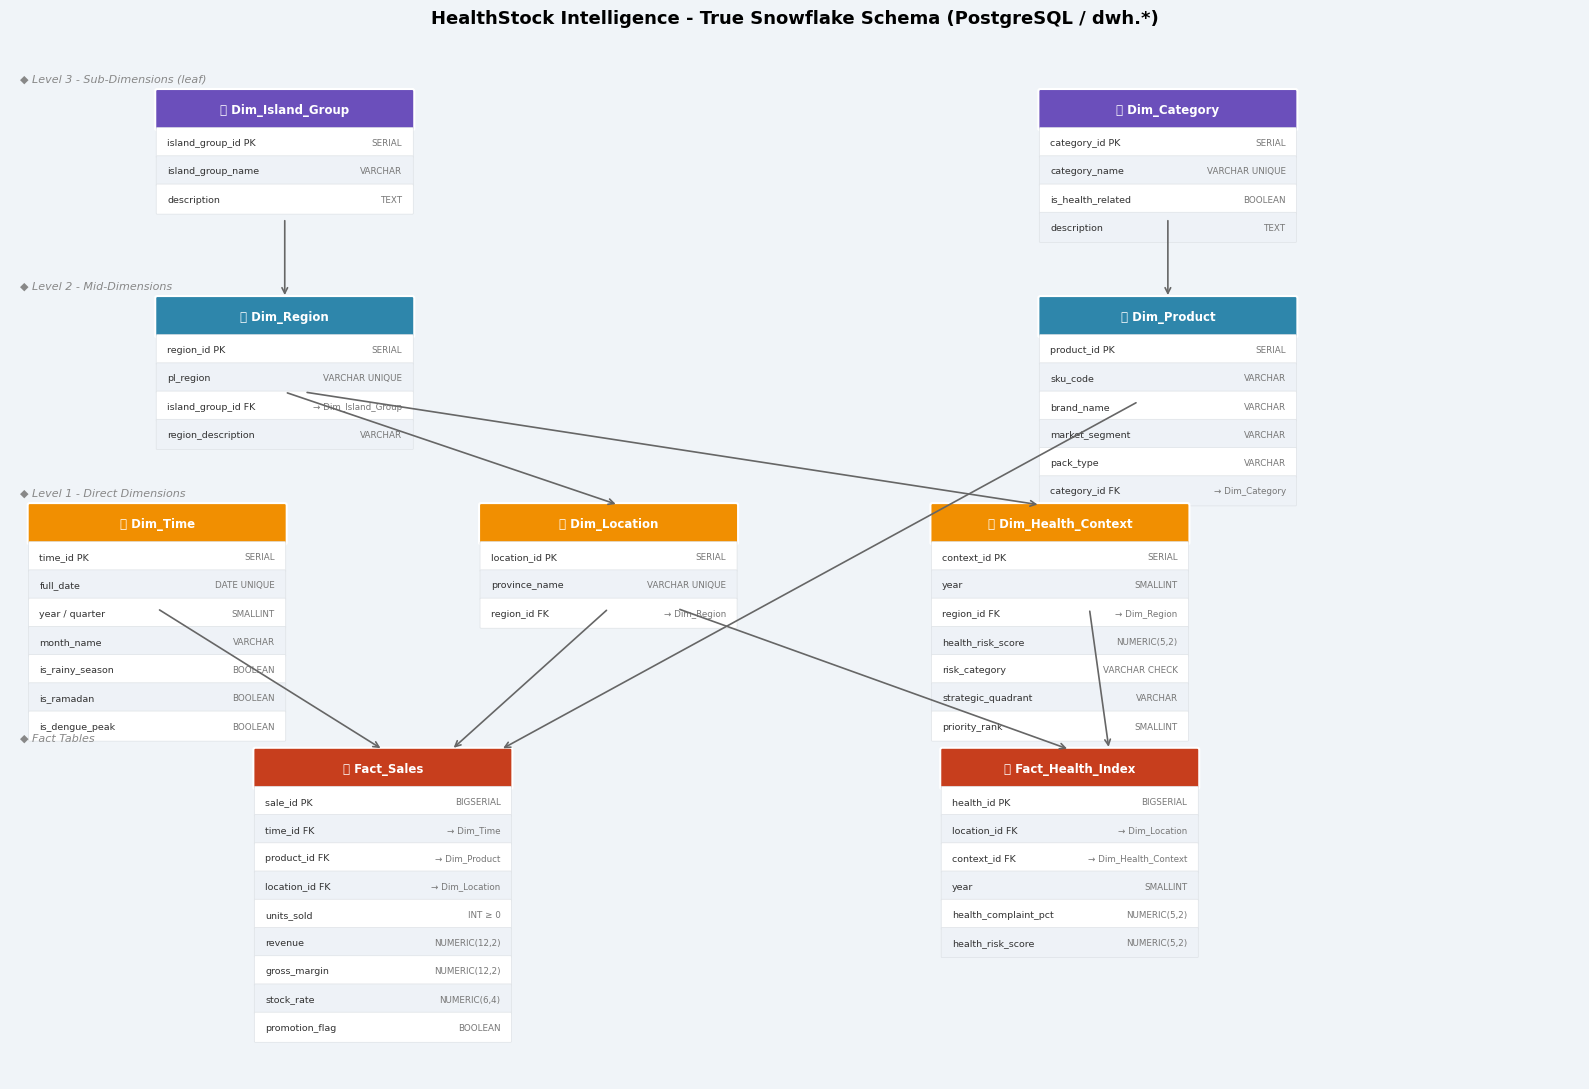

In [33]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.set_xlim(0, 16); ax.set_ylim(0, 11)
ax.axis("off"); ax.set_facecolor("#F0F4F8")
fig.patch.set_facecolor("#F0F4F8")
ax.set_title("HealthStock Intelligence - True Snowflake Schema (PostgreSQL / dwh.*)",
             fontsize=13, fontweight="bold", pad=15)

# Layer labels
for y_pos, label, color in [
    (10.6, "◆ Level 3 - Sub-Dimensions (leaf)", "#888"),
    (8.4,  "◆ Level 2 - Mid-Dimensions",        "#888"),
    (6.2,  "◆ Level 1 - Direct Dimensions",      "#888"),
    (3.6,  "◆ Fact Tables",                       "#888"),
]:
    ax.text(0.1, y_pos, label, fontsize=8, color=color, style="italic")

def draw_table(ax, x, y, title, fields, color, width=2.6, row_h=0.30):
    header_h = 0.40
    ax.add_patch(mpatches.FancyBboxPatch(
        (x, y - header_h), width, header_h,
        boxstyle="round,pad=0.02", facecolor=color, edgecolor="white", linewidth=1.5))
    ax.text(x + width/2, y - header_h/2, title,
            ha="center", va="center", fontsize=8.5, fontweight="bold", color="white")
    for i, (fname, ftype) in enumerate(fields):
        row_y = y - header_h - (i + 1) * row_h
        bg = "#FFFFFF" if i % 2 == 0 else "#EEF2F7"
        ax.add_patch(mpatches.FancyBboxPatch(
            (x, row_y), width, row_h,
            boxstyle="round,pad=0.01", facecolor=bg, edgecolor="#DEE2E6", linewidth=0.5))
        ax.text(x + 0.1, row_y + row_h/2, fname,
                ha="left", va="center", fontsize=6.8, color="#333")
        ax.text(x + width - 0.1, row_y + row_h/2, ftype,
                ha="right", va="center", fontsize=6.3, color="#777")

#  Level 3: Sub-Dimensions 
draw_table(ax, 1.5, 10.5, "🌏 Dim_Island_Group", [
    ("island_group_id PK", "SERIAL"),
    ("island_group_name",  "VARCHAR"),
    ("description",        "TEXT"),
], color="#6B4FBB")

draw_table(ax, 10.5, 10.5, "🏷️ Dim_Category", [
    ("category_id PK",    "SERIAL"),
    ("category_name",     "VARCHAR UNIQUE"),
    ("is_health_related", "BOOLEAN"),
    ("description",       "TEXT"),
], color="#6B4FBB")

#  Level 2: Mid-Dimensions 
draw_table(ax, 1.5, 8.3, "🗺️ Dim_Region", [
    ("region_id PK",       "SERIAL"),
    ("pl_region",          "VARCHAR UNIQUE"),
    ("island_group_id FK", "→ Dim_Island_Group"),
    ("region_description", "VARCHAR"),
], color="#2E86AB")

draw_table(ax, 10.5, 8.3, "📦 Dim_Product", [
    ("product_id PK",  "SERIAL"),
    ("sku_code",       "VARCHAR"),
    ("brand_name",     "VARCHAR"),
    ("market_segment", "VARCHAR"),
    ("pack_type",      "VARCHAR"),
    ("category_id FK", "→ Dim_Category"),
], color="#2E86AB")

#  Level 1: Direct Dimensions 
draw_table(ax, 0.2, 6.1, "📅 Dim_Time", [
    ("time_id PK",      "SERIAL"),
    ("full_date",       "DATE UNIQUE"),
    ("year / quarter",  "SMALLINT"),
    ("month_name",      "VARCHAR"),
    ("is_rainy_season", "BOOLEAN"),
    ("is_ramadan",      "BOOLEAN"),
    ("is_dengue_peak",  "BOOLEAN"),
], color="#F18F01")

draw_table(ax, 4.8, 6.1, "📍 Dim_Location", [
    ("location_id PK", "SERIAL"),
    ("province_name",  "VARCHAR UNIQUE"),
    ("region_id FK",   "→ Dim_Region"),
], color="#F18F01")

draw_table(ax, 9.4, 6.1, "🩺 Dim_Health_Context", [
    ("context_id PK",      "SERIAL"),
    ("year",               "SMALLINT"),
    ("region_id FK",       "→ Dim_Region"),
    ("health_risk_score",  "NUMERIC(5,2)"),
    ("risk_category",      "VARCHAR CHECK"),
    ("strategic_quadrant", "VARCHAR"),
    ("priority_rank",      "SMALLINT"),
], color="#F18F01")

#  Facts 
draw_table(ax, 2.5, 3.5, "📊 Fact_Sales", [
    ("sale_id PK",       "BIGSERIAL"),
    ("time_id FK",       "→ Dim_Time"),
    ("product_id FK",    "→ Dim_Product"),
    ("location_id FK",   "→ Dim_Location"),
    ("units_sold",       "INT ≥ 0"),
    ("revenue",          "NUMERIC(12,2)"),
    ("gross_margin",     "NUMERIC(12,2)"),
    ("stock_rate",       "NUMERIC(6,4)"),
    ("promotion_flag",   "BOOLEAN"),
], color="#C73E1D")

draw_table(ax, 9.5, 3.5, "🏥 Fact_Health_Index", [
    ("health_id PK",         "BIGSERIAL"),
    ("location_id FK",       "→ Dim_Location"),
    ("context_id FK",        "→ Dim_Health_Context"),
    ("year",                 "SMALLINT"),
    ("health_complaint_pct", "NUMERIC(5,2)"),
    ("health_risk_score",    "NUMERIC(5,2)"),
], color="#C73E1D")

#  Arrows 
arrow_style = dict(arrowstyle="<-", color="#666", lw=1.2)

# Island_Group ← Region
ax.annotate("", xy=(2.8, 9.15), xytext=(2.8, 8.3), arrowprops=arrow_style)
# Category ← Product
ax.annotate("", xy=(11.8, 9.15), xytext=(11.8, 8.3), arrowprops=arrow_style)
# Region ← Location
ax.annotate("", xy=(2.8, 7.3), xytext=(6.2, 6.1), arrowprops=arrow_style)
# Region ← Health_Context
ax.annotate("", xy=(3.0, 7.3), xytext=(10.5, 6.1), arrowprops=arrow_style)
# Product ← Fact_Sales
ax.annotate("", xy=(11.5, 7.2), xytext=(5.0, 3.5), arrowprops=arrow_style)
# Time ← Fact_Sales
ax.annotate("", xy=(1.5, 5.0), xytext=(3.8, 3.5), arrowprops=arrow_style)
# Location ← Fact_Sales
ax.annotate("", xy=(6.1, 5.0), xytext=(4.5, 3.5), arrowprops=arrow_style)
# Location ← Fact_Health
ax.annotate("", xy=(6.8, 5.0), xytext=(10.8, 3.5), arrowprops=arrow_style)
# Health_Context ← Fact_Health
ax.annotate("", xy=(11.0, 5.0), xytext=(11.2, 3.5), arrowprops=arrow_style)

plt.tight_layout()
plt.savefig(f"{PROCESSED}dwh_snowflake_diagram.png", dpi=150, bbox_inches="tight")
plt.show()

In [34]:
print(f"Sub-Dimensions : dim_island_group, dim_category")
print(f"Mid-Dimensions : dim_region, dim_product")
print(f"Direct Dims    : dim_time, dim_location, dim_health_context")
print(f"Fact Tables    : fact_sales, fact_health_index")
print(f"Total Tables   : {len(tables)}")
print(f"Database       : postgresql://{DB_HOST}/{DB_NAME}/dwh.*")

Sub-Dimensions : dim_island_group, dim_category
Mid-Dimensions : dim_region, dim_product
Direct Dims    : dim_time, dim_location, dim_health_context
Fact Tables    : fact_sales, fact_health_index
Total Tables   : 9
Database       : postgresql://localhost/healthstock_dwh/dwh.*
